# SHAP Decision Plots - Part I
SHAP decision plots are used to understand how complex models make predictions. In this notebook, we use a simple example to demonstrate the features of decision plots.

In Part II <link>, we ///

# Load the dataset and train the model
We use LightGBM and the standard UCI Adult income dataset to predict whether an individual makes over $50K per year. There are just 12 features in the dataset.

In [7]:
#///
import shap
X,y = shap.datasets.adult()
X.columns.to_list()

SyntaxError: invalid syntax (decision.py, line 248)

In [3]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import numpy as np

random_state = 7

X,y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

SyntaxError: invalid syntax (decision.py, line 248)

# Calculate SHAP values
We compute SHAP values and SHAP interaction values for the first 20 test observations. Our model uses log odds, so the SHAP values reflect changes in log odds.

In [30]:
explainer = shap.TreeExplainer(model)
select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)
print(f"Explainer expected value: {explainer.expected_value}")

Explainer expected value: -2.429696895229237


# Basic decision plot features
A decision plot shows how a model assigns prediction values (i.e., how the model makes decisions). This overview refers to the plot below.
* The x-axis represents the model's output. In this case, the units are log odds.
* The plot is centered on the x-axis at `explainer.expected_value`. All SHAP values are relative to the expected value.
* The y-axis represents the change in SHAP values for each feature. By default, the features are ordered by descending importance relative to the observations in the plot. *This may not be the same order as the feature importance for the entire dataset.* User-defined feature ordering and hierarchical cluster ordering are also supported.
* Each observation is represented by a colored line. At the top of the plot, each observation's line strikes the x-axis at its predicted value. Moving down the plot, SHAP values for each feature are subtracted from the model's predictions. This shows the change in SHAP values for each feature.
* At the bottom of the plot, all observations converge at `explainer.expected_value`.

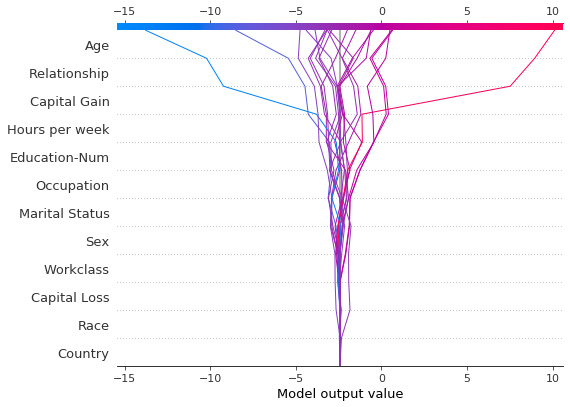

In [28]:
shap.decision_plot(explainer.expected_value, shap_values, features, matplotlib=True)

As with force plots, the decision plot supports `link='logit'` to transform log odds to probabilities.

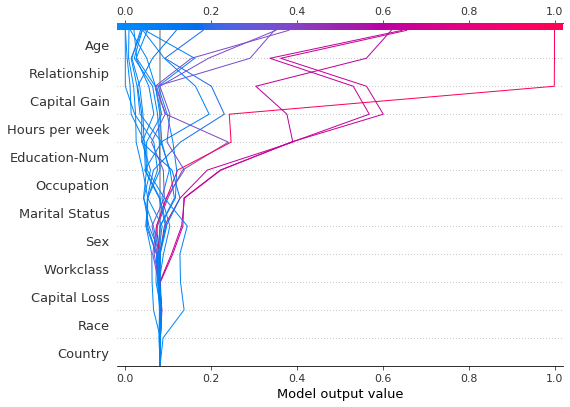

In [29]:
shap.decision_plot(explainer.expected_value, shap_values, features, link='logit', matplotlib=True)

We can highlight individual observations in the plot. For example, we can highlight the misclassified observations as follows.

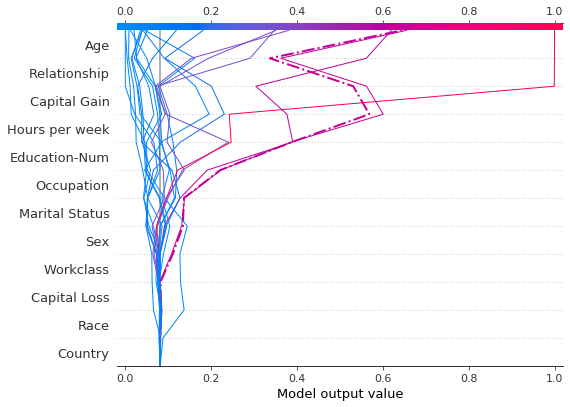

In [31]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + explainer.expected_value) > 0

# Highlighted observations can be specified by integer index or bool array.
misclassified = y_pred != y_test[select]
shap.decision_plot(explainer.expected_value, shap_values, features, 
                   highlight=misclassified, link='logit', matplotlib=True)

Let's inspect the misclassified observation by plotting it alone. In the plot below, the observation's line has changed shape. Why? The feature importances (y-axis) have changed order corresponding to the effects for this single observation. ///do display_features here. probably in the other places also so it is consistent when we do JS.

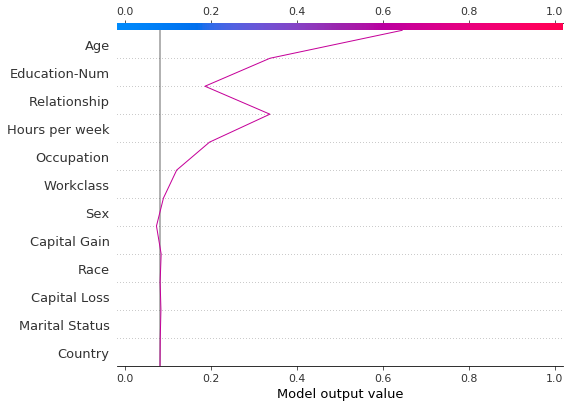

In [6]:
shap.decision_plot(explainer.expected_value, shap_values[misclassified], 
                   features[misclassified], link='logit', matplotlib=True)

The force plot for the same observation is plotted below. In this case, both plots are effective at showing the model's decision. The decision plot is generally more helpful than the force plot when the cumulative effects of many features are involved in the overall decision. We will show such a case in Part II.///

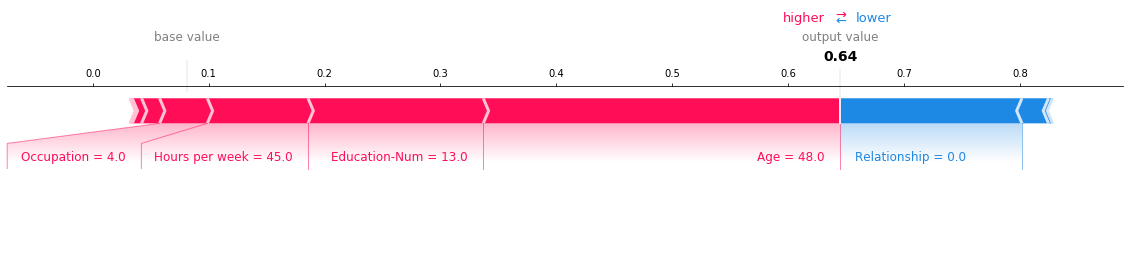

In [7]:
shap.force_plot(explainer.expected_value, shap_values[misclassified], 
                   features[misclassified], link='logit', matplotlib=True)

# Feature order
The decision plot currently features three orderingss: 'importance' for feature importance (the default), 'hclust' for hierarchical clustering, and 'none'. The following plot features 'hclust' ordering.

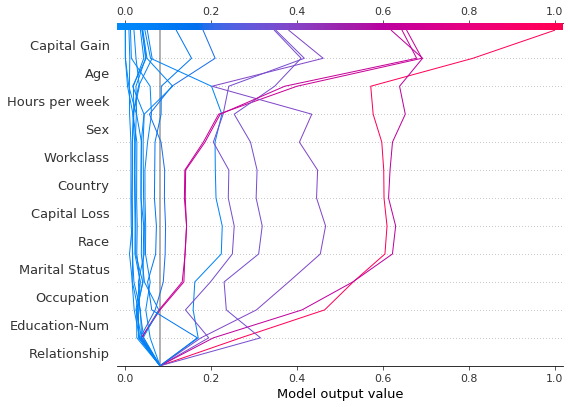

In [15]:
shap.decision_plot(explainer.expected_value, shap_values, features, 
                   feature_order='hclust', link='logit', matplotlib=True)

The feature order can be changed from descending to ascending. In the next plot, we use ascending feature importance ordering.

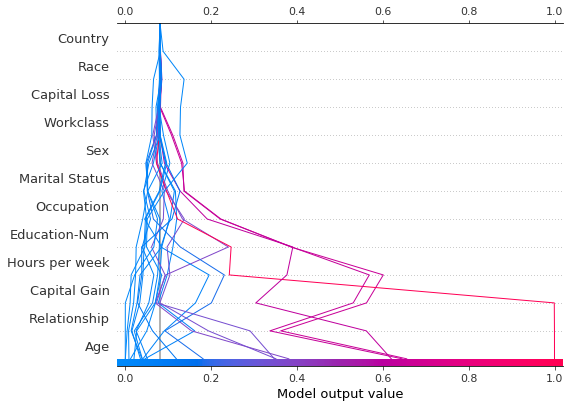

In [17]:
shap.decision_plot(explainer.expected_value, shap_values, features, ascending=True, link='logit', matplotlib=True)

# SHAP interaction values
The decision plot also supports plotting SHAP interaction values. The following plot displays an interaction plot in log odds units and descending feature importance. Notice that the lines do not completely converge to `explainer.expected_value` at the bottom of the plot. This is because there are N(N + 1)/2 = 12(13)/2 = 78 features (including interaction and main effects). The decision plot shows the top 20 features by default. To show more or less features, set the y_lim argument as we show in the next section.

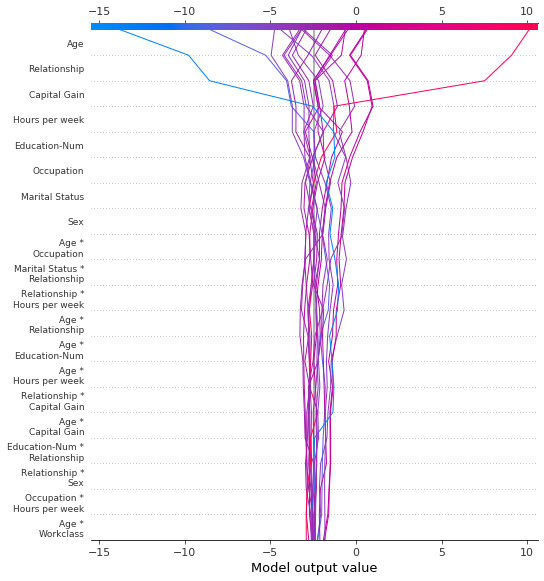

In [32]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, features, matplotlib=True)

# Changing the display window
///show how to use y_lim

The next plot shows all 144 features using 'hclust' ordering.///nope. do (None, 20) and (-20, None) Scroll to the very bottom to see which features contribute most to the cluster separation.

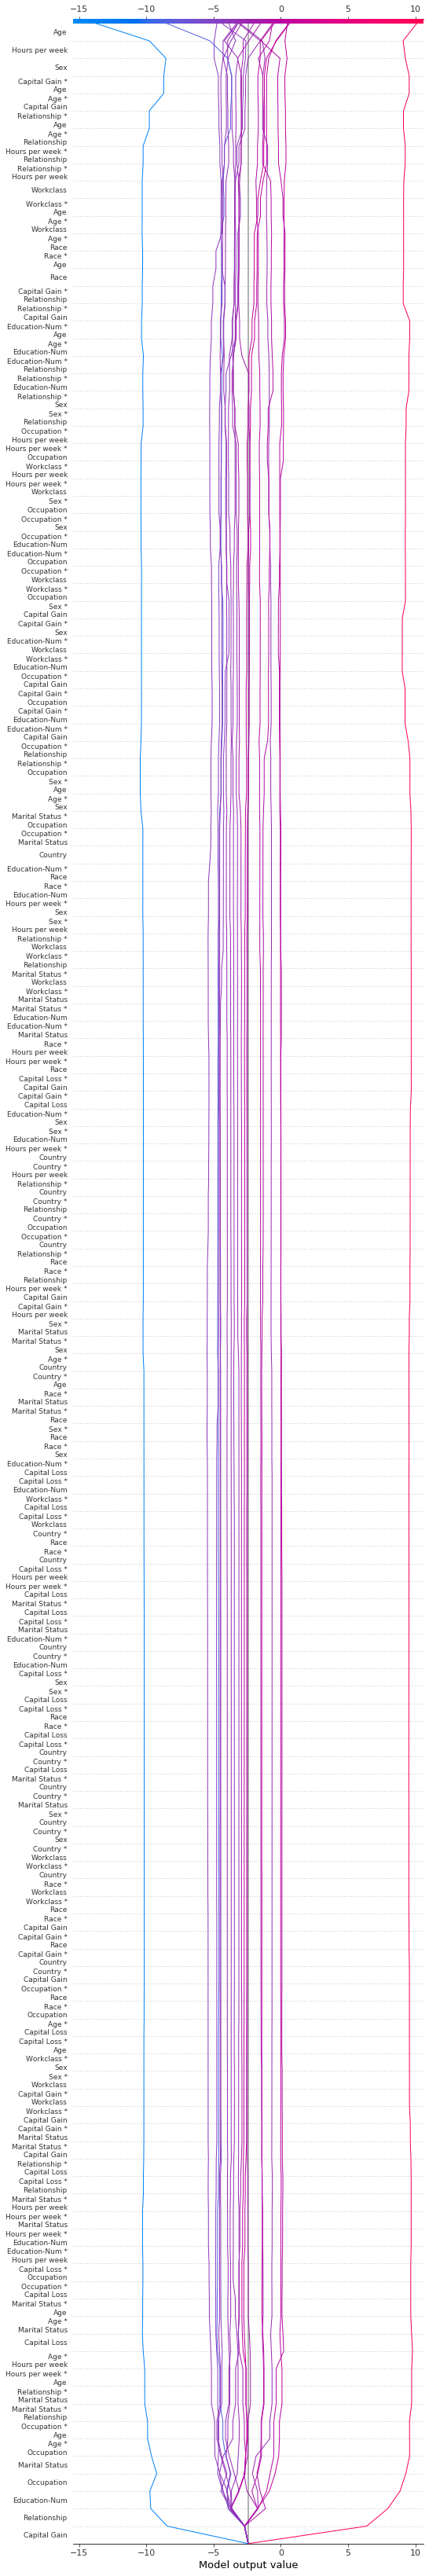

In [36]:
shap.decision_plot(explainer.expected_value, shap_interaction_values, 
                   features, feature_order='hclust', max_display=np.Inf, matplotlib=True)

# Displaying the cumulative effect of many features
In practice, most of the datasets we use have many features. The decision plot is particularly useful in visualizing the cumulative effects of several features. Many datasets that we use have many features. To demonstrate the cumulative effect of many features, we will plot the SHAP interaction values.

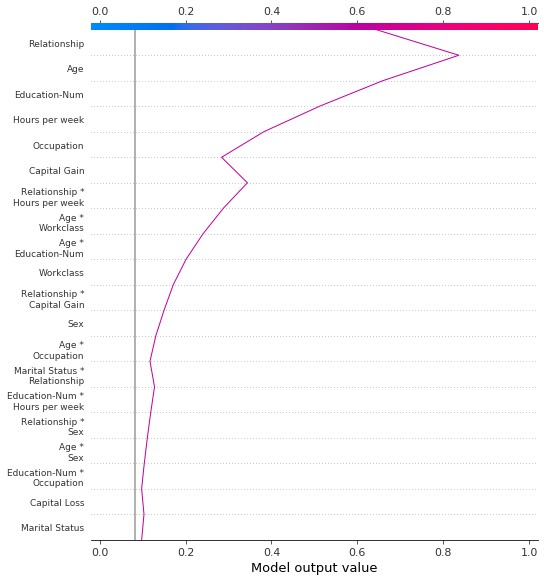

In [26]:
shap.decision_plot(explainer.expected_value, shap_interaction_values[misclassified], 
                   features[misclassified], link='logit', matplotlib=True)

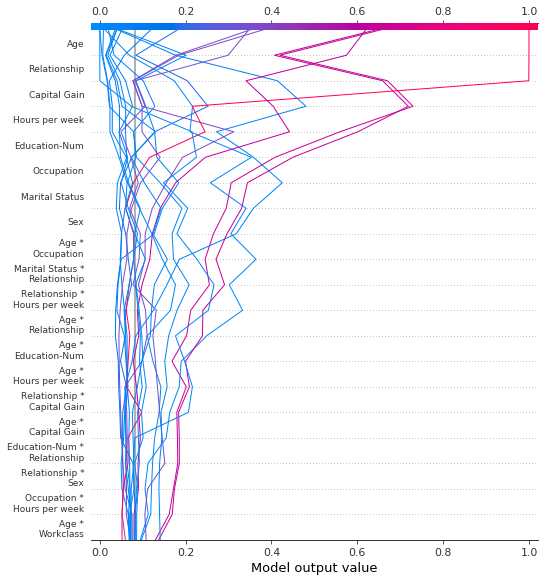

In [25]:
# Highlighted observations can be specified by integer index or bool array.
shap.decision_plot(explainer.expected_value, shap_interaction_values, features, link='logit', matplotlib=True)

# Changing the base value (shifting the center of the plot)

As with force plots, the decision plot supports `link='logit'` to transform the output to probabilities. Note that we are using the shifted SHAP values so the plot is centered at probability 0.5. In the plot below, the positive predictions are far more pronounced.

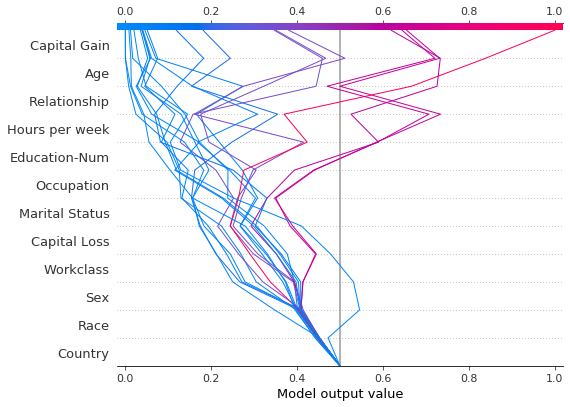

In [7]:
shap.decision_plot(0, shap_shifted, features, link='logit', matplotlib=True)

As with force plots, the decision plot supports `link='logit'` to transform the output to probabilities. Note that we are using the shifted SHAP values so the plot is centered at probability 0.5. In the plot below, the positive predictions are far more pronounced.

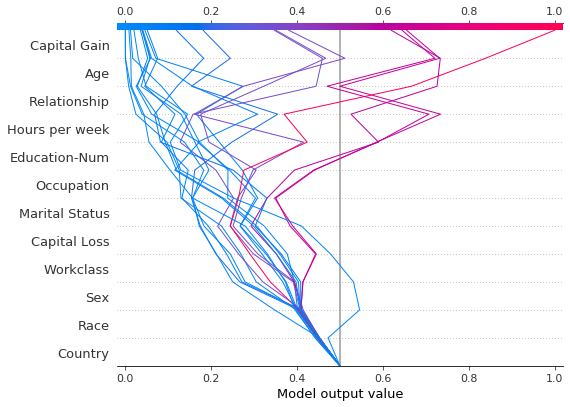

In [7]:
shap.decision_plot(0, shap_shifted, features, link='logit', matplotlib=True)

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values, features, matplotlib=True, ascending=True)

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values, features, matplotlib=True, link='logit')

# Shifting the decision plot's center
The `explainer.expected_value` must be specified for the decision plot to produce correct results. `explainer.expected_value` is the mean of the raw model predictions for the training data.

In [ ]:
print(model.predict(X_train, raw_score=True).mean())
print(explainer.expected_value)

All SHAP values produced by the explainer are relative to this mean. Hence, to reproduce model predictions, the SHAP values are summed then added to the mean as shown here.

In [ ]:
print(shap_values[0].sum() + explainer.expected_value)
print(model.predict(features.iloc[[0]].values, raw_score=True)[0]) # Prints the log-odds.

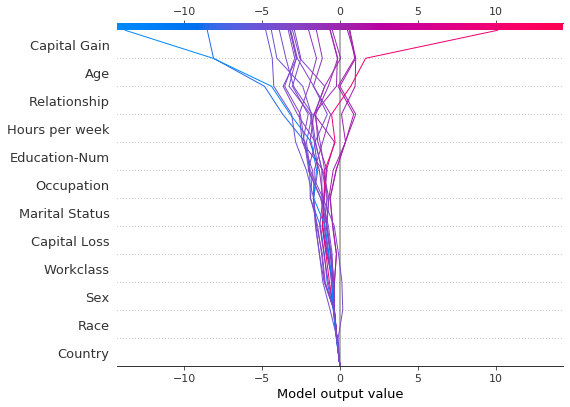

In [5]:
# SHAP values are relative to the explainer.expected_value.
shap_shifted = shap_values + (explainer.expected_value / shap_values.shape[1])
shap.decision_plot(0, shap_shifted, features, matplotlib=True)